In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
print(device)

cuda


In [6]:
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_file, transform=None, is_test=False):
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform
        self.is_test = is_test
        
    def __len__(self):
        return len(self.data_frame)
    
    def __getitem__(self, index):
        item = self.data_frame.iloc[index]
        
        if self.is_test:
            image = item.values.reshape(28,28).astype(np.uint8)
            label = None
        else:
            image = item[1:].values.reshape(28,28).astype(np.uint8)
            label = item.iloc[0]
            
        image = transforms.ToPILImage()(image)
        
        if self.transform is not None:
            image = self.transform(image)
            
        if self.is_test:
            return image
        else:
            return image, label

In [11]:
transform = transforms.Compose([
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5,),(0.5,))   
])

In [12]:
train_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/train.csv', transform=transform, is_test=False)
test_dataset = CustomMNISTDataset(csv_file='/kaggle/input/digit-recognizer/test.csv', transform=transform, is_test=True)

In [13]:
print("Train Size: " + str(len(train_dataset)) + ", Test Size: " + str(len(test_dataset)))

Train Size: 42000, Test Size: 28000


In [14]:
train_dataset[1]

(tensor([[[-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000],
          [-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -1.0000,
           -1.0000, -1.0000, -1.000

In [16]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

Input Size:  torch.Size([64, 1, 28, 28])


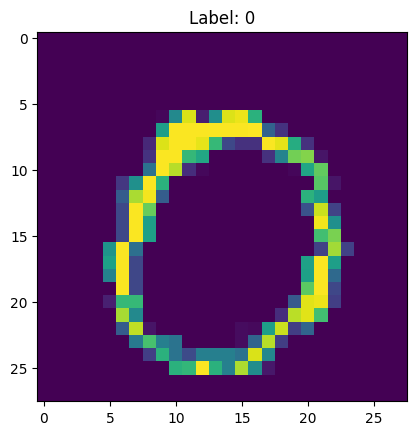

In [19]:
for example_data, example_labels in train_loader:
    example_image = example_data[0]
    print("Input Size: ", example_data.size())
    
    example_image_numpy = example_image.permute(1,2,0).numpy()
    
    plt.imshow(example_image_numpy)
    plt.title(f"Label: {example_labels[0]}")
    plt.show()
    
    break

In [21]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(128 * 7 * 7, 128)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128,20)
        self.fc3 = nn.Linear(20,10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)
        
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.pool(x)
        
        x_size = x.size(1) * x.size(2) * x.size(3)
        
        x = x.view(-1, x_size)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return x
        

In [22]:
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
num_epochs = 20
running_loss = 0.0

for epoch in range(num_epochs):
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs.float())
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if i % 100 == 99:
            print(f"[{epoch + 1}, {i + 1}] Loss: {running_loss / 100:.3f}")
            running_loss = 0.0
            
print("Training Finished")

[1, 100] Loss: 0.041
[1, 200] Loss: 0.044
[1, 300] Loss: 0.037
[1, 400] Loss: 0.033
[1, 500] Loss: 0.038
[1, 600] Loss: 0.036
[2, 100] Loss: 0.065
[2, 200] Loss: 0.034
[2, 300] Loss: 0.033
[2, 400] Loss: 0.038
[2, 500] Loss: 0.044
[2, 600] Loss: 0.035
[3, 100] Loss: 0.057
[3, 200] Loss: 0.037
[3, 300] Loss: 0.036
[3, 400] Loss: 0.035
[3, 500] Loss: 0.038
[3, 600] Loss: 0.040
[4, 100] Loss: 0.049
[4, 200] Loss: 0.034
[4, 300] Loss: 0.028
[4, 400] Loss: 0.034
[4, 500] Loss: 0.041
[4, 600] Loss: 0.032
[5, 100] Loss: 0.058
[5, 200] Loss: 0.032
[5, 300] Loss: 0.032
[5, 400] Loss: 0.029
[5, 500] Loss: 0.035
[5, 600] Loss: 0.036
[6, 100] Loss: 0.045
[6, 200] Loss: 0.034
[6, 300] Loss: 0.037
[6, 400] Loss: 0.025
[6, 500] Loss: 0.034
[6, 600] Loss: 0.039
[7, 100] Loss: 0.049
[7, 200] Loss: 0.029
[7, 300] Loss: 0.031
[7, 400] Loss: 0.028
[7, 500] Loss: 0.034
[7, 600] Loss: 0.030
[8, 100] Loss: 0.047
[8, 200] Loss: 0.028
[8, 300] Loss: 0.027
[8, 400] Loss: 0.029
[8, 500] Loss: 0.033
[8, 600] Loss

In [26]:
model.eval()
predictions = []

with torch.no_grad():
    for data in test_loader:
        data = data.to(device)
        
        outputs = model(data)
        _, predicted= torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().tolist())
        
submission = pd.DataFrame({
    "ImageID": range(1, len(predictions) + 1),
    "Label" : predictions
})

submission.to_csv('predictions_3_13_1.csv', index = False);